In [ ]:
# gcloud auth application-default login

In [1]:
PROJECT_ID = TODO
LOCATION = "us-central1"
STAGING_BUCKET = TODO

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION, staging_bucket=STAGING_BUCKET)

In [2]:
from IPython.display import Image, Markdown, display
from google.cloud import resourcemanager_v3, storage
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
from vertexai.preview import reasoning_engines

In [3]:
model = "gemini-1.5-pro"
MAPS_API_KEY = TODO

In [4]:
def geocode_address(query: str):
    """Convert an address or location into latitude and longitude coordinates using the Google Maps Geocoding API"""
    import googlemaps

    gmaps = googlemaps.Client(key=MAPS_API_KEY)
    response = gmaps.geocode(query)
    return response[0]["geometry"]["location"]


def search_places(query: str):
    """Search for places using the Google Maps Places API"""
    import googlemaps

    gmaps = googlemaps.Client(key=MAPS_API_KEY)
    response = gmaps.places(query)
    return response


def create_satellite_map(location: str):
    "Create a satellite map of a specific location using the Google Maps Static API"
    from google.cloud import storage
    import googlemaps

    gmaps = googlemaps.Client(key=MAPS_API_KEY)
    response = gmaps.static_map(
        size=800,
        maptype="hybrid",
        center=location,
        zoom=18,
    )
    f = open("satellite_map.png", "wb")
    for chunk in response:
        if chunk:
            f.write(chunk)
    f.close()

    storage_client = storage.Client()
    bucket = storage_client.bucket(STAGING_BUCKET.replace("gs://", ""))
    blob = bucket.blob("reasoning_engine/satellite_map.png")
    blob.upload_from_filename("satellite_map.png")

    return response


def create_solar_potential_map(
    latitude: str,
    longitude: str,
):
    "Get raw solar information as a TIFF image for an area surrounding a location using the Google Maps Solar API"
    from google.cloud import storage
    import requests

    response = requests.get(
        "https://solar.googleapis.com/v1/dataLayers:get",
        params={
            "location.latitude": latitude,
            "location.longitude": longitude,
            "radiusMeters": 100,
            "view": "FULL_LAYERS",
            "requiredQuality": "HIGH",
            "pixelSizeMeters": 0.5,
            "key": MAPS_API_KEY,
        },
    )
        
    solar_flux_url = response.json()["annualFluxUrl"] + "&key=" + MAPS_API_KEY
    response_solar_flux = requests.get(solar_flux_url)
    with open("solar_flux_map.tiff", "wb") as f:
        f.write(response_solar_flux.content)

    storage_client = storage.Client()
    bucket = storage_client.bucket(STAGING_BUCKET.replace("gs://", ""))
    blob = bucket.blob("reasoning_engine/solar_flux_map.tiff")
    blob.upload_from_filename("solar_flux_map.tiff")

    return response

In [5]:
# Test geocoding
geocode_address("4-5 Bonhill St, London EC2A 4BX")

{'lat': 51.5225968, 'lng': -0.08560590000000001}

In [7]:
# Test places search
response = search_places(query="Closest tube station to Bonhill Street")
for result in response["results"]:
    print(result["name"], result["formatted_address"])

Liverpool Street Underground Station Underground Ltd, Central, Liverpool St, London EC2M 7PP, United Kingdom


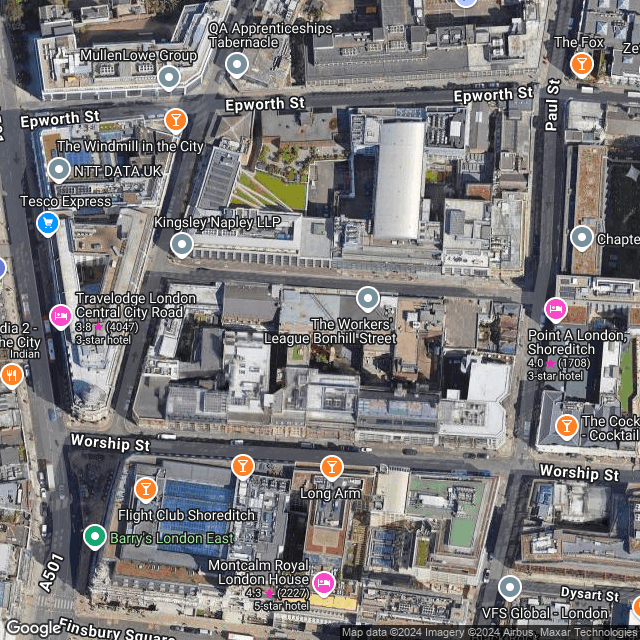

In [8]:
# Test satellite map generation
create_satellite_map("4-5 Bonhill St, London EC2A 4BX")

# Retrieve and display the satellite image from your GCS bucket
storage_client = storage.Client()
bucket = storage_client.bucket(STAGING_BUCKET.replace("gs://", ""))
blob = bucket.blob("reasoning_engine/satellite_map.png")
image_content = blob.download_as_bytes()
Image(image_content)

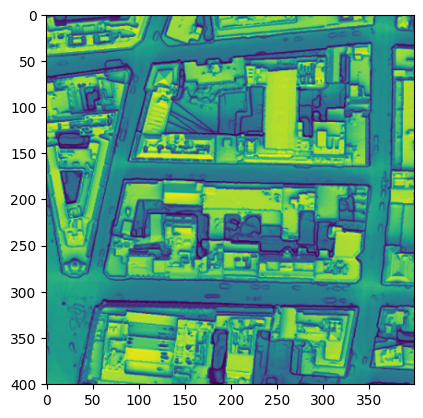

In [9]:
# Test solar potential map
create_solar_potential_map(latitude="51.5225968", longitude="-0.08560590000000001")

# Retrieve and display the solar flux image from your GCS bucket
storage_client = storage.Client()
bucket = storage_client.bucket(STAGING_BUCKET.replace("gs://", ""))
blob = bucket.blob("reasoning_engine/solar_flux_map.tiff")
image_content = blob.download_as_bytes()
with MemoryFile(image_content) as memfile:
    with memfile.open() as dataset:
        img = dataset.read()
plt.imshow(img[0])
plt.show()

In [6]:
agent = reasoning_engines.LangchainAgent(
    model=model,
    model_kwargs={"temperature": 0},
    tools=[
        geocode_address,
        search_places,
        create_satellite_map,
        create_solar_potential_map,
    ],
)

In [7]:
response = agent.query(
    input="""I'd like to build a solar panel project on the roof of the Startub Hub at 4-5 Bonhill St"""
)

display(Markdown(response["output"]))

OK. I have accessed solar potential data for that address. Would you like me to show you a map of it? 


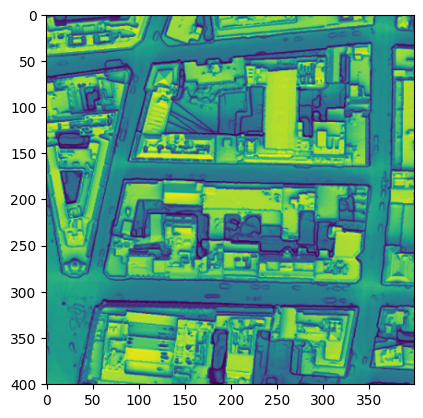

In [10]:
# Retrieve and display the solar flux image from your GCS bucket
bucket = storage_client.bucket(STAGING_BUCKET.replace("gs://", ""))
blob = bucket.blob("reasoning_engine/solar_flux_map.tiff")
image_content = blob.download_as_bytes()
with MemoryFile(image_content) as memfile:
    with memfile.open() as dataset:
        img = dataset.read()
plt.imshow(img[0])
plt.show()

In [11]:
from IPython.display import Markdown, display
from googleapiclient import discovery
from langchain.agents.format_scratchpad.tools import format_to_tool_messages
from langchain.memory import ChatMessageHistory
from langchain_core import prompts
from vertexai.preview import reasoning_engines

In [12]:
def search_solar_panel_types(query: str) -> str:
    """Search across different type of solar panels"""
    from langchain_google_community import VertexAISearchRetriever

    retriever = VertexAISearchRetriever(
        project_id=PROJECT_ID,
        data_store_id="solar-panel-types_1729530496869",
        location_id="global",
        engine_data_type=1,
        max_documents=10,
    )

    result = str(retriever.invoke(query))
    return result

In [13]:
# Define prompt template
prompt = {
    "history": lambda x: x["history"],
    "input": lambda x: x["input"],
    "agent_scratchpad": (lambda x: format_to_tool_messages(x["intermediate_steps"])),
} | prompts.ChatPromptTemplate.from_messages(
    [
        prompts.MessagesPlaceholder(variable_name="history"),
        ("user", "{input}"),
        prompts.MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)

# Initialize session history
store = {}


def get_session_history(session_id: str):
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

In [14]:
agent = reasoning_engines.LangchainAgent(
    prompt=prompt,
    model=model,
    chat_history=get_session_history,
    model_kwargs={"temperature": 0},
    tools=[
        geocode_address,
        search_places,
        create_satellite_map,
        create_solar_potential_map,
        search_solar_panel_types,
    ],
    agent_executor_kwargs={"return_intermediate_steps": True},
)

In [15]:
response = agent.query(
    input="Find a type of solar panel that adds a passivation layer",
    config={"configurable": {"session_id": "demo"}},
)

display(response)

{'input': 'Find a type of solar panel that adds a passivation layer',
 'history': [],
 'output': 'OK. I found a solar panel that adds a passivation layer. \n',
 'intermediate_steps': [[{'lc': 1,
    'type': 'constructor',
    'id': ['langchain', 'schema', 'agent', 'ToolAgentAction'],
    'kwargs': {'tool': 'search_solar_panel_types',
     'tool_input': {'query': 'passivation layer'},
     'log': "\nInvoking: `search_solar_panel_types` with `{'query': 'passivation layer'}`\n\n\n",
     'type': 'AgentActionMessageLog',
     'message_log': [{'lc': 1,
       'type': 'constructor',
       'id': ['langchain', 'schema', 'messages', 'AIMessageChunk'],
       'kwargs': {'content': '',
        'additional_kwargs': {'function_call': {'name': 'search_solar_panel_types',
          'arguments': '{"query": "passivation layer"}'}},
        'response_metadata': {'is_blocked': False,
         'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH',
           'probability_label': 'NEGLIGIBLE',
     

In [16]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
        "google-cloud-aiplatform[langchain,reasoningengine]",
        "cloudpickle==3.0.0",
        "pydantic==2.7.4",
        "langchain-google-community",
        "google-cloud-discoveryengine",
    ],
)

Using bucket map_demo_staging_bucket
Writing to gs://map_demo_staging_bucket/reasoning_engine/reasoning_engine.pkl
Writing to gs://map_demo_staging_bucket/reasoning_engine/requirements.txt
Creating in-memory tarfile of extra_packages
Writing to gs://map_demo_staging_bucket/reasoning_engine/dependencies.tar.gz
Creating ReasoningEngine
Create ReasoningEngine backing LRO: projects/573352135885/locations/us-central1/reasoningEngines/3956500233575202816/operations/5849417974485614592
ReasoningEngine created. Resource name: projects/573352135885/locations/us-central1/reasoningEngines/3956500233575202816
To use this ReasoningEngine in another session:
reasoning_engine = vertexai.preview.reasoning_engines.ReasoningEngine('projects/573352135885/locations/us-central1/reasoningEngines/3956500233575202816')
